In [2]:
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.nn import relu, tanh
from jax.config import config
#from jax.config import config; config.update("jax_enable_x64", True)
from jax.tree_util import tree_leaves, tree_unflatten, tree_structure, tree_flatten, tree_map

from tqdm import tqdm
import itertools
from functools import partial
from torch.utils import data
import matplotlib.pyplot as plt


## Define the MLP function
We start by defining a multi-layer perceptron (MLP) function, which will be the basis for our BNN:

In [3]:
def mlp(layers, activation=relu):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2, k3 = random.split(key, 3)
            W = random.normal(k1, (d_in, d_out))
            b = random.normal(k1, (d_out,))
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

## Helper functions for random PyTrees
The parameters in the neural networks within the BNN are stored as nested lists of Jax NumPy arrays. To perturb these arrays with random noise, we shall define a couple helper functions:

- `random_split_like_tree` - creates a PyTree of PRNGKeys to allow us to apply the random operator
- `tree_random_normal_like` - perturbs our parameters with i.i.d Gaussian noise

In [4]:
def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = tree_structure(target)
    keys = random.split(rng_key, treedef.num_leaves)
    return tree_unflatten(treedef, keys)

def tree_random_normal_like(rng_key, target, std):
    keys_tree = random_split_like_tree(rng_key, target)
    return tree_map(lambda l, k: l + std * random.normal(k, l.shape, l.dtype), target, keys_tree)

## Define our BNN

Next, we define an `Ensemble_BNN` class that will initialize and evaluate the ensemble of network making up our BNN. This BNN will be trained using a EKI algorithm similar to [here](https://arxiv.org/abs/1808.03620). Below is a algorithm detailing the EKI algorithm utilized in this code:


![EKI Pseudocode](https://drive.google.com/uc?id=1Oe4bEptEmjFEF5L1OHUPiNyLs7CJzcVc
)


For this notebook $\boldsymbol{\xi}$ is the set of neural network parameters, $\mathcal{G}_i$ is the neural network evaluated over the $i$th minibatch, $R$ is a covariance matrix representing the uncertainty in the measurements, $Q$ is a evolution covariance on the parameters $\boldsymbol{\xi}$, chosen as a hyperparameter of this algorithm, and $p(\boldsymbol{\xi})$ is a i.i.d. standard normal distribution.

In [18]:
# Define the model
class Ensemble_BNN:
    def __init__(self, network_layers, N_ensemble, activation=relu, rng_key=random.PRNGKey(0)):    
        # Network initialization and evaluation functions
        key_net, key = random.split(rng_key, 2)
        self.net_init, self.net_apply = mlp(network_layers, activation)
        self.N_ensemble = N_ensemble
        self.v_params = vmap(self.net_init)(random.split(key_net, N_ensemble))
        self.flat_arrays, self.treedef = tree_flatten(self.v_params)
        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    
    @partial(jit, static_argnums=(0,))
    def flatten_params(self, v_params):
        # Flatten the pytree
        flat_arrays, _ = tree_flatten(v_params)
        # Concatenate the arrays into a single vector
        flat_arrays_list = [np.reshape(array, (self.N_ensemble,-1)) for array in flat_arrays]
        flat_vector = np.concatenate(flat_arrays_list,1)
        return flat_vector.T

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flat_vector):
        # Reshape the vector back into a list of arrays with the same shapes as the original flattened arrays
        start_idx = 0
        reshaped_arrays = []
        flat_vector = flat_vector.T
        for array in self.flat_arrays:
            size = array[0,:].size
            shape = array.shape
            reshaped_arrays.append(np.reshape(flat_vector[:,start_idx : start_idx + size], shape))
            start_idx += size
        new_v_params = tree_unflatten(self.treedef, reshaped_arrays)
        return new_v_params

    @partial(jit, static_argnums=(0,))
    def avg_misfit_loss(self, v_params, batch):        
        x, y = batch
        num_data = len(y)
        Y = vmap(self.net_apply, in_axes=(0, None))(v_params, x).squeeze(2).T
        loss = np.mean(np.linalg.norm(y-Y,axis=1))
        return loss

    @partial(jit, static_argnums=(0,))
    def eki_step(self, v_params, batch, std_data, key):        
        # Get data, output, and covariance terms
        x, y = batch
        num_data = len(y)
        
        # Define output, innovation, and measurement covariance
        R = std_data**2*np.ones(y.size)
        sqrt_R_vec = np.sqrt(R).reshape((num_data,1))
        Y = vmap(self.net_apply, in_axes=(0, None))(v_params, x).squeeze(2).T
        d = y - Y + sqrt_R_vec*random.normal(key, Y.shape)
        Y_mean = np.mean(Y, axis=1, keepdims=1)            
        YY = (Y - Y_mean) / np.sqrt(self.N_ensemble - 1)
        C_yy = YY @ YY.T
            
        # Get Parameter terms
        X = self.flatten_params(v_params)
        X_mean = np.mean(X, axis=1, keepdims=1)
        XX = (X - X_mean) / np.sqrt(self.N_ensemble - 1)
        C_xy = XX @ YY.T

        # Apply EKI
        v_params_flat = X + C_xy @ (np.linalg.solve(C_yy + np.diag(R), d))
        v_params = self.unflatten_params(v_params_flat)
        return v_params

    # Optimize parameters in a loop
    def eki_train(self, key, dataset, n_iter = 10000, std_params=0.002, std_data=0.01):
        key_next, key_X, key_Y  = random.split(key, 3)
            
        # Data initialization
        data = iter(dataset)

        # Functions
        random_perturb = lambda key, std_params, params: tree_random_normal_like(key, params, std_params)
        v_params = self.v_params

        # Main training loop
        for it in tqdm(range(n_iter)):
            key_next, key_X, key_Y, key_adaptive = random.split(key_next, 4)
            v_params = random_perturb(key_X, std_params, v_params)
            batch = next(data)
            v_params = self.eki_step(v_params, batch, std_data, key_Y)
            loss = self.avg_misfit_loss(v_params, batch)
            self.loss_log.append(loss)
        self.v_params = v_params
        
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict(self, x):
      pred_s = vmap(self.net_apply, (0, None))(self.v_params, x)
      return pred_s.squeeze(2).T

## Data Generation
We define a `DataGenerator_batch` class to handle data batching for training our BNN:

In [19]:
class DataGenerator_batch(data.Dataset):
  def __init__(self, x, y, batch_size=64, rng_key=random.PRNGKey(1)):
    'Initialization'
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.key = rng_key
    self.n_data, self.n_dim = x.shape

  def __getitem__(self, index):
    'Generate one batch of data'
    self.key, subkey = random.split(self.key)
    idx = random.choice(subkey, self.n_data, (self.batch_size,), replace=False)
    return self.x[idx,:], self.y[idx,:]

## Simple noisy sin function approximation

$$ y=\sin(\pi x) + \epsilon,\quad \epsilon\sim\mathcal{N}(0,0.1)$$ 

The goal of this example is to learn an ensemble of approximations of the function $y$, representing the uncertainty in our prediction. Here, we will utilize $500$ noisy samples of $y$. The evolutaion covariance $Q=\sigma_\xi^2 I$, where $\sigma=0.02$ and $I$ is the identity matrix. Additionally, the measurment covariance matrix $R$ is chosen to be $R=\sigma_y^2I$ where $\sigma_y=0.1$

We utilize a dense neural network with 2 hidden layers, 20 neurons, and $\tanh$ activation function.

In [20]:
key_data, key_dataset, key_model, key_train, key_noise = random.split(random.PRNGKey(10),5)
n_samples = 500
batch_size = 100
N_ensemble = 1000
n_iter = 500
std_params = 0.02
std_data = 0.1

x = random.normal(key_data,(n_samples,1))
y = np.sin(np.pi*x) + std_data*random.normal(key_noise,x.shape)

dataset = DataGenerator_batch(x, y, batch_size = batch_size, rng_key = key_dataset)
network_layers = [1,20,20,1]
activation = tanh
bnn = Ensemble_BNN(network_layers, N_ensemble, activation = activation, rng_key = key_model)

bnn.eki_train(key_train, dataset, n_iter = n_iter, std_params = std_params, std_data = std_data)

100%|██████████| 500/500 [00:12<00:00, 40.47it/s]


## Ploting

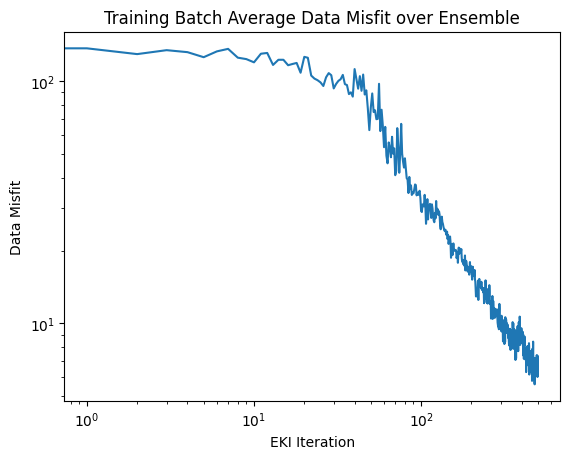

In [21]:
plt.loglog(bnn.loss_log)
plt.title('Training Batch Average Data Misfit over Ensemble')
plt.xlabel('EKI Iteration')
plt.ylabel('Data Misfit')
plt.show()

Text(0.5, 0, '$y$')

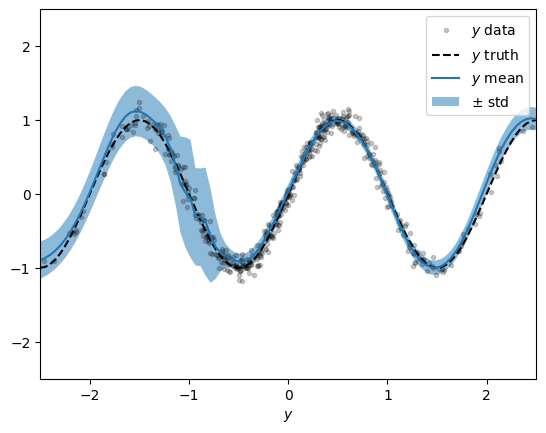

In [9]:
x_test = np.linspace(-2.5,2.5,100).reshape(-1,1)
y_test = bnn.predict(x_test)
y_truth = np.sin(np.pi*x_test)

y_mean = np.mean(y_test,axis=1)
y_std = np.std(y_test,axis=1)

plt.figure()
plt.plot(x,y,'k.',alpha=0.2,label='$y$ data')
plt.plot(x_test,y_truth,'--k',label='$y$ truth')
plt.plot(x_test,y_mean,label='$y$ mean')
plt.fill_between(x_test.flatten(),y_mean-y_std,y_mean+y_std,alpha=0.5,label='$\pm$ std')

plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.legend()
plt.xlabel('$x$')
plt.xlabel('$y$')